In [9]:
import argparse
import json
import os.path as osp

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from models.resnet import make_resnet101_base
from datasets.imagenet import ImageNet

%matplotlib inline 
import matplotlib.pyplot as plt
# KNN search map
from sklearn.manifold import TSNE
import scipy.io as sio
import os
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F

In [10]:
s = 'n00004475 organism-> n00015388 animal-> n01466257 chordate-> n01471682 vertebrate-> n01861778 mammal-> n01886756 placental-> n02370806 ungulate-> n02394477 even_toed_ungulate-> n02399000 ruminant-> n02401031 bovid-> n02407959 Old_World_buffalo-> n02408429 water_buffalo'
# s = 'n00021939 artifact-> n03575240 instrumentality-> n03183080 device-> n03574816 instrument-> n04565375 weapon-> n03467984 gun-> n03343853 firearm-> n02759963 autoloader-> n02760429 automatic_firearm-> n03701391 machine_gun-> n02760855 automatic_rifle'
wnids = s.split()[::2]
imagenet_path = 'materials/datasets/imagenet'
dataset = ImageNet(imagenet_path)
dataset.set_keep_ratio(0.5)

cnn = make_resnet101_base()
cnn.load_state_dict(torch.load('materials/resnet101-base.pth'))
# cnn = cnn.cuda()
cnn.eval()

wnids_feats = {wnid:[] for wnid in wnids}
valid = [] 
for wnid in wnids:
    subset = dataset.get_subset(wnid)
    if subset.valid:
        valid.append(wnid)
        loader = DataLoader(dataset=subset, batch_size=1,
                            shuffle=False, num_workers=2)
        for batch_id, batch in enumerate(loader, 1):
            data, label = batch # image_tensor, wnid
            data = data
            feat = cnn(data) # (batch_size, d)
            wnids_feats[wnid].extend(feat.detach().cpu().tolist())


no class n00004475


In [15]:
for k,v in wnids_feats.items():
    print(k, len(v))
del wnids[0]
del wnids[1]
del wnids[7]

n00004475 0
n00015388 786
n01466257 2
n01471682 522
n01861778 664
n01886756 349
n02370806 616
n02394477 314
n02399000 582
n02401031 134
n02407959 590
n02408429 625


In [139]:
s = 'n00004475 organism-> n00015388 animal-> n01466257 chordate-> n01471682 vertebrate-> n01861778 mammal-> n01886756 placental-> n02370806 ungulate-> n02394477 even_toed_ungulate-> n02399000 ruminant-> n02401031 bovid-> n02407959 old_world_buffalo-> n02408429 water_buffalo'
# s = 'n00021939 artifact-> n03575240 instrumentality-> n03183080 device-> n03574816 instrument-> n04565375 weapon-> n03467984 gun-> n03343853 firearm-> n02759963 autoloader-> n02760429 automatic_firearm-> n03701391 machine_gun-> n02760855 automatic_rifle'
wd = {wnid:name.split('-')[0] for wnid, name in zip(s.split()[::2],s.split()[1::2])}


In [140]:
wd

{'n00004475': 'organism',
 'n00015388': 'animal',
 'n01466257': 'chordate',
 'n01471682': 'vertebrate',
 'n01861778': 'mammal',
 'n01886756': 'placental',
 'n02370806': 'ungulate',
 'n02394477': 'even_toed_ungulate',
 'n02399000': 'ruminant',
 'n02401031': 'bovid',
 'n02407959': 'old_world_buffalo',
 'n02408429': 'water_buffalo'}

In [128]:
# tsne visulization together
tsne = TSNE()
wnids_feats_tsne = {wnid:[] for wnid in wnids}
feats_tsne = np.array([]).reshape(0, 2048)
label_tsne = []
for idx, wnid in enumerate(wnids):
    feats = np.array(wnids_feats[wnid])
    feats_tsne = np.vstack((feats_tsne, feats))
    label_tsne.extend([idx]*len(feats))
    print(wnid, feats.shape)
feats_tsne = tsne.fit_transform(feats_tsne)

n00015388 (786, 2048)
n01471682 (522, 2048)
n01861778 (664, 2048)
n01886756 (349, 2048)
n02370806 (616, 2048)
n02394477 (314, 2048)
n02399000 (582, 2048)
n02407959 (590, 2048)
n02408429 (625, 2048)


/home/zzc/anaconda3/envs/exp/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zzc/anaconda3/envs/exp/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [87]:
idx = np.argwhere(np.array(label_tsne)==0).squeeze()

animal all 786
animal left 786
vertebrate all 522
vertebrate left 522
mammal all 664
mammal left 664
placental all 349
placental left 349
ungulate all 616
ungulate left 616
even_toed_ungulate all 314
even_toed_ungulate left 314
ruminant all 582
ruminant left 582
old_world_buffalo all 590
old_world_buffalo left 590
water_buffalo all 625
water_buffalo left 625


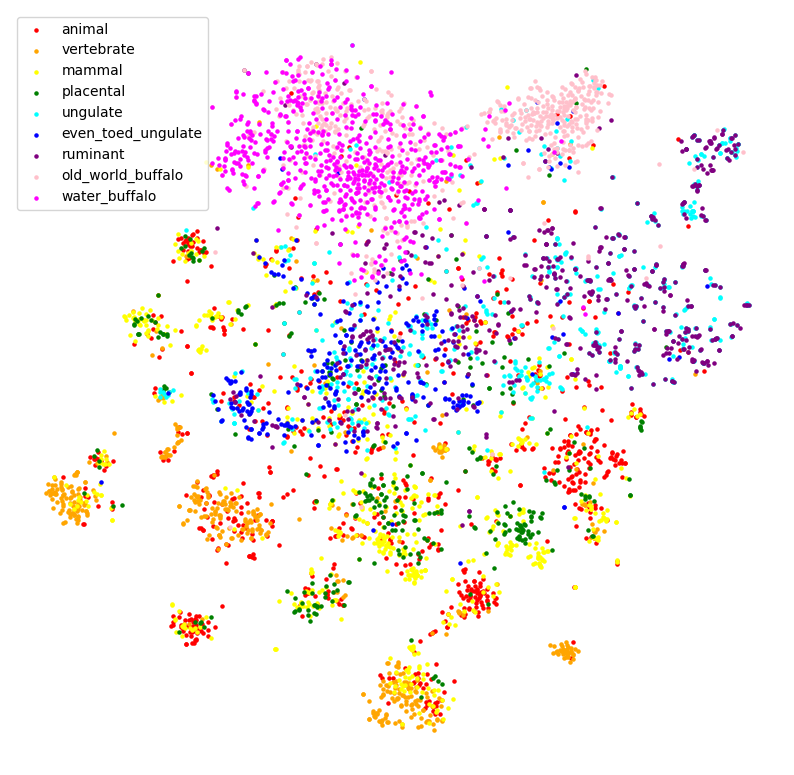

In [141]:
# plot performance of attributes num 

plt.figure(figsize=(10, 10),dpi=100)
plt.axis('off')  #去掉坐标轴
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']

max_ = 134
import random
for idx, wnid in enumerate(wnids):
    l_idx = np.argwhere(np.array(label_tsne)==idx).squeeze()
    feats = feats_tsne[l_idx]
    print(wd[wnid], 'all', len(feats))
    #feats = np.array(random.sample(list(feats), max_))
    print(wd[wnid], 'left', len(feats))
    plt.scatter(feats[:,0], feats[:,1],  c=cs[idx],label=wd[wnid], s=5) # cyan
#     plt.title(wd[wnid]+str(len(feats)), fontsize=14)

plt.legend(loc='upper left')

#plt.suptitle("t-SNE visualization of path nodes:artifact->automatic_rifle",fontsize=16, y=0)
plt.savefig("t-SNE_visualization_of_path_nodes_agg.png", bbox_inches='tight',orientation='landscape')
plt.show()


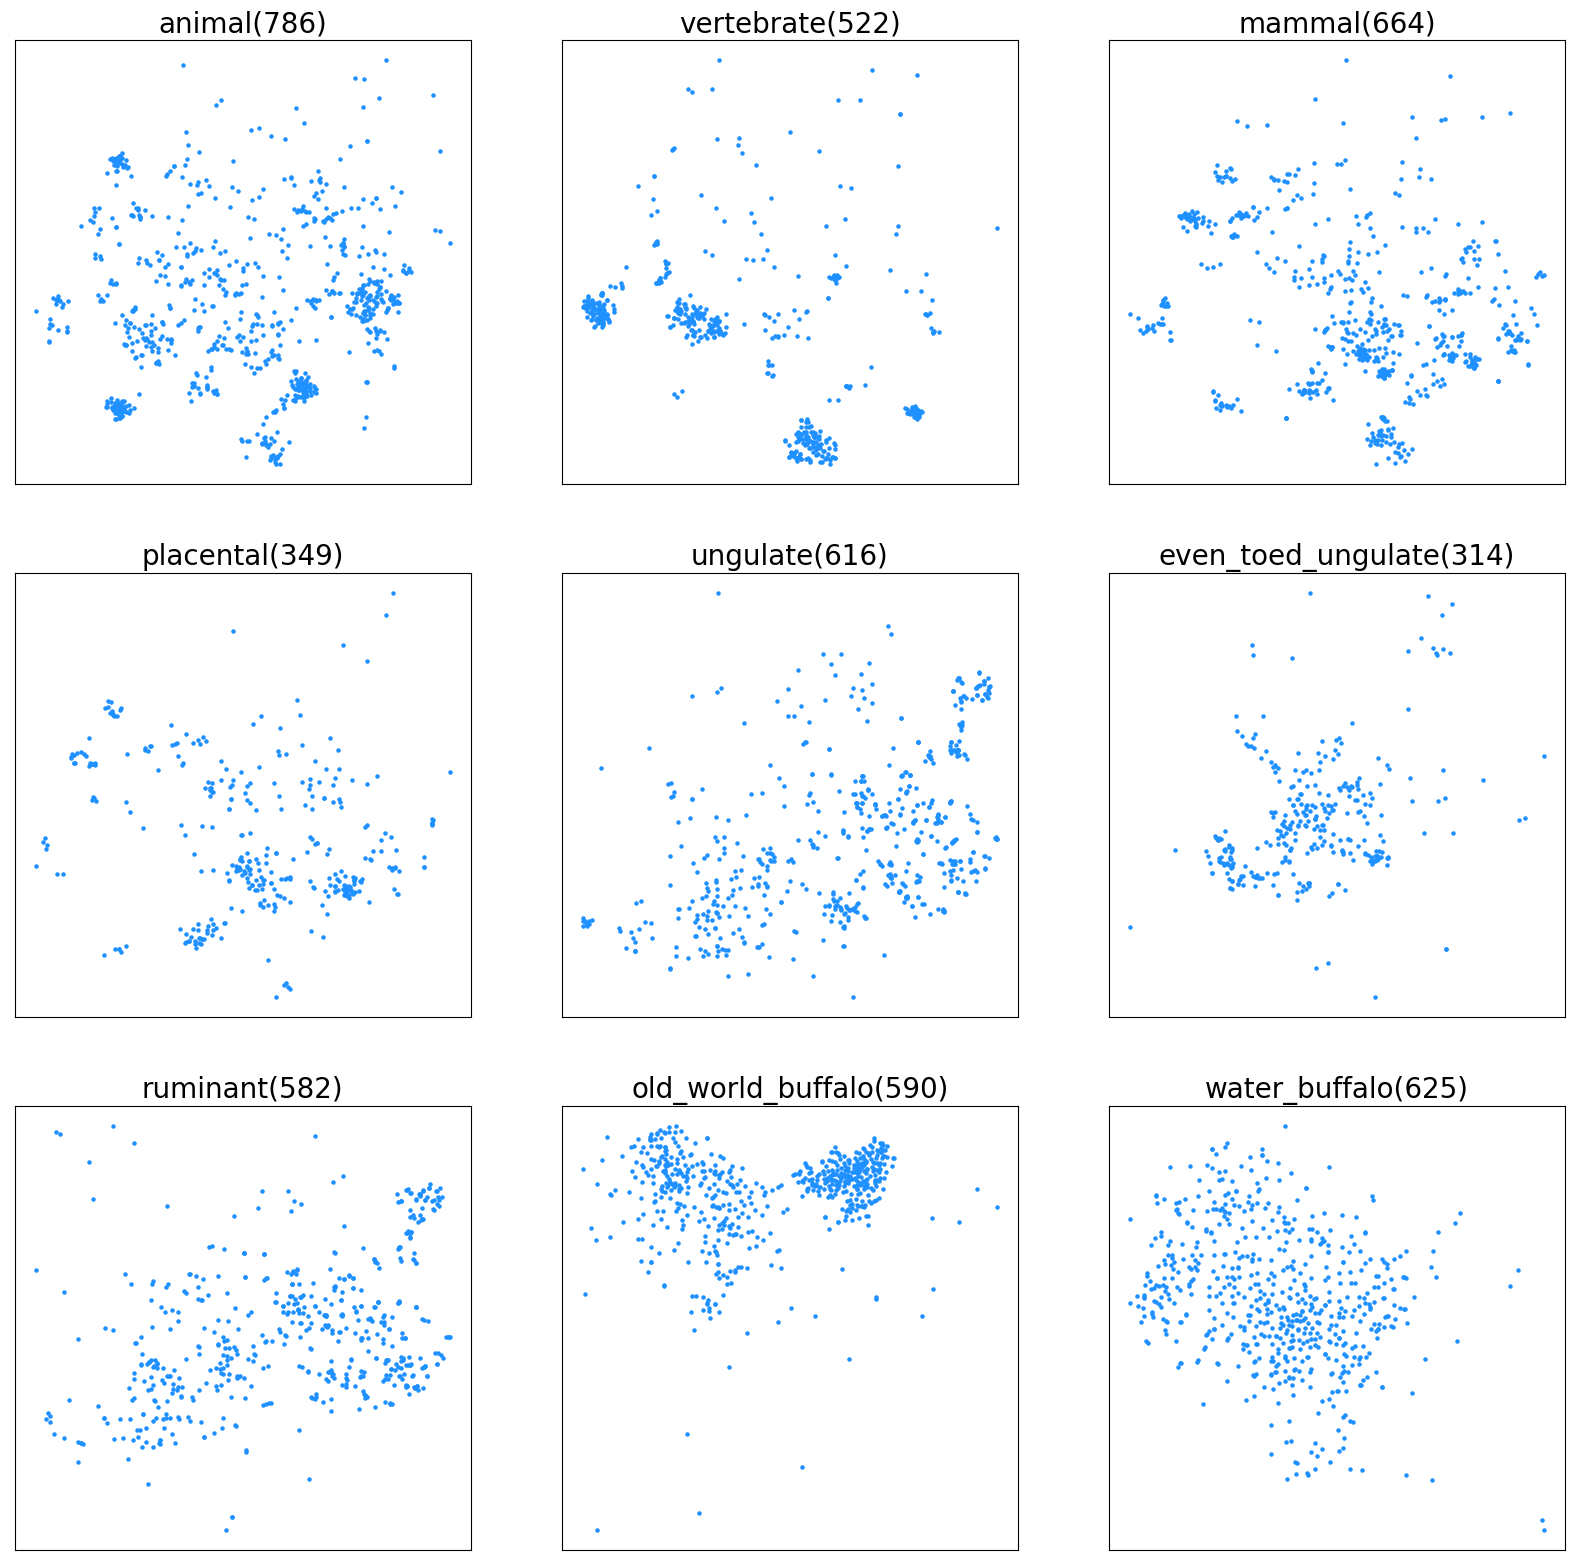

In [142]:
# plot performance of attributes num 

plt.figure(figsize=(20, 20),dpi=100)
max_ = 134
import random

for idx, wnid in enumerate(wnids):
    plt.subplot(3, 3, idx+1)
#     feats = wnids_feats_tsne[wnid]
   # plt.axis('off')  #去掉坐标轴
    idx = np.argwhere(np.array(label_tsne)==idx).squeeze()
    feats = feats_tsne[idx]
    # feats = np.array(random.sample(list(feats), max_))
    plt.scatter(feats[:,0], feats[:,1],  c='#1E90FF', s=5) # cyan
    plt.title(wd[wnid]+f'({str(len(feats))})', fontsize=20)

    frame = plt.gca()
    # y 轴不可见
    frame.axes.get_yaxis().set_visible(False)
    frame.axes.get_xaxis().set_visible(False)

#plt.suptitle("t-SNE visualization of path nodes:artifact->automatic_rifle",fontsize=16, y=0)
plt.savefig("t-SNE_visualization_of_path_nodes_sep.png", bbox_inches='tight',orientation='landscape')
plt.show()


In [144]:
a = [23.9,37.7,57.32,69.88,79.6]
b = 19.3
c = 23.9/19.3
for aa in a:
    print(aa/c)

19.3
30.44393305439331
46.28769874476988
56.43029288702929
64.27949790794979
